# Main Notebook

## README

## Project Overview
This project demonstrates a complete workflow from synthetic population to synthetic order generation. It provides a reusable foundation for further logistics analysis and modeling.

## Installation & Dependencies
- See details in *environment.yml* file.


## Data Description
- **Input Data**: 
    - [2021 UK census data](https://www.ons.gov.uk/census)
    - [Statista](https://www.statista.com/markets/413/topic/457/b2c-e-commerce/#overview)
- **Output Data**: 
    - Synthetic population with different instance size. 
    - Synthetic orders with different instance size and random seeds. 

## Code / Notebook Structure
- **1 Synthetic Population**: Using census data to set constrains and using Iterative Proportional Fitting to fit the synthetic population.  
- **2 Synthetic Order**: Using multi-sources to model the e-commerce behaviour, then generate synthetic orders with different population size and random seeds.
- **3 Data Generation Framework Validation**: Introduce third-party source to validate the effectiveness of the proposed method.

## Usage
1. Clone or download the project  
2. Launch Jupyter Notebook in your local environment  
3. Run the notebook cells in sequence to complete the simulation and population synthesis workflow  

## Results / Visualization
The notebook outputs synthetic population results and corresponding visualizations, providing an intuitive view of the outcomes.

## Init

In [1]:
import sys
from pathlib import Path
SRC_PATH = Path().resolve() / 'src'
sys.path.append(str(SRC_PATH))


## 1 Synthetic Population

### 1.1 Population Synthesize

### 1.0 Init

In [2]:
from src.config import DATA_21CEN_PATH, DATA_GIS_PATH, RES_STATIC, RES_SYN_POP_PATH

#### 1.1.1 Base Population

In [3]:
from src.cases import get_census_2021_base_population
from src.functional_segments import aggregate_dict

# Get base population from 2021 census
inner_london_microdata_file = DATA_21CEN_PATH / 'census_microdata_2021_inner_london.csv'
base_pop = get_census_2021_base_population(inner_london_microdata_file, simplified=True)  # including simplify recode, 174646 rows

# Get population variables 
pop_variables = ["age", "sex", "ethnic_group", "economic_activity", "number_of_cars_and_vans", "marital_status",  ]   # variables in syn population, won't affect constraints "approximated_social_grade",
base_pop_select = base_pop.select(pop_variables)
agg_base_pop = base_pop_select.aggregate()  # aggregate to 1796 rows    # 4328 rows(add approximated_social_grade)

# store weights of aggregate population into a dictionary
agg_pop_dict = aggregate_dict(agg_base_pop.records) 

#### 1.1.2 Set Constraints

In [4]:
import pandas as pd
from src.get_marginal_distribution import marg_age_dist, marg_sex_dist,marg_ethnic_dist, marg_ecoact_dist, marg_car_dist, marg_leptnershp_dist

# Get marginal distributions (constraints)
marg_age        = marg_age_dist(space_level='MSOA')         # only MSOA available, so need further process
marg_sex        = marg_sex_dist(space_level='LSOA')
marg_ethnic     = marg_ethnic_dist(space_level='LSOA')
marg_ecoact     = marg_ecoact_dist(space_level='LSOA')
marg_car        = marg_car_dist(space_level='LSOA')
marg_partner    = marg_leptnershp_dist(space_level='LSOA')

# change MSOA level Age distribution to LSOA level, introducing assumptions:
# Assumption: granular LSOA areas in each MSOA level have same Age distribution, represented by MSOA Age distribution
ILA_coding = pd.read_csv(RES_STATIC/ 'Coding_Scheme_LMSOA_LAD.csv')
marg_age_lsoa_coding = ILA_coding[['LSOA_CODE','MSOA_CODE']]
marg_age = marg_age_lsoa_coding.merge(marg_age, left_on='MSOA_CODE', right_on='GEO_CODE').drop('MSOA_CODE', axis=1).set_index('LSOA_CODE')
marg_age = pd.concat([marg_age, pd.DataFrame([marg_age.mean(axis=0)], index=["TOTAL"])])  # add TOTAL line
marg_age.index.rename('GEO_CODE', inplace=True)

#### 1.1.3 Population Synthesis in LSOA level (Proportional)

In [ ]:
import geopandas as gpd
from src.basics import Constraints
from src.synthesizer import IPF, SA

# Read Shape file to get the Encoding of each area
ILA_shp_file = DATA_GIS_PATH / 'Inner_London_Boundary' / 'inner_london_lsoa.shp'   # if MSOA level, use inner_london_msoa.shp
ILA_gpd = gpd.read_file(ILA_shp_file)

ILA_gpd = ILA_gpd[['lsoa21cd', 'geometry']]
ILA_gpd.rename(columns={'lsoa21cd': 'GEO_CODE'}, inplace=True)
ILA_gpd.set_index('GEO_CODE', inplace=True)

# Get constrain variables
constraint_variables = ["age", "sex", "ethnic_group", "economic_activity", "number_of_cars_and_vans", "marital_status",]      # variables for constraint, subset of pop_variables
constraint_var_dict = {var: base_pop.demographics.var_code_cate[var] for var in constraint_variables}
agg_base_pop.records[constraint_variables] = agg_base_pop.records[constraint_variables].astype(int)     # all the var values are int type (0, 1, 2, 3...)

synthetic_population_per_area = {}    # dict to save the population in each areas

# Iteratively calculate the person-type proportion in each area
for i, area_code in enumerate(ILA_gpd.index):
    print(f"Synthesizing {area_code}: {i+1}/{len(ILA_gpd.index)}----------------------------------------")
        
    # Constrains
    area_constraint = Constraints(var_code_cate=constraint_var_dict,
                                    var_marg_dist={
                                        "age": marg_age.loc[area_code].to_dict(),
                                        "sex": marg_sex.loc[area_code].to_dict(),
                                        "economic_activity": marg_ecoact.loc[area_code].to_dict(),
                                        "ethnic_group": marg_ethnic.loc[area_code].to_dict(),
                                        "number_of_cars_and_vans": marg_car.loc[area_code].to_dict(),
                                        "marital_status": marg_partner.loc[area_code].to_dict(),
                                    })

    # IPF fitting and evaluation
    ipf_syn = IPF(base_population=agg_base_pop, constraints=area_constraint)
    area_syn_pop = ipf_syn.synthesize(max_iter = 1000, stop_threshold = 0.001)
    synthetic_population_per_area[area_code] = area_syn_pop
    ipf_syn.describe_results()
    print('\n')


Save the Population proportion to csv file.

In [ ]:
# Save the output as csv files
output_records = []

for area_code, pop_obj in synthetic_population_per_area.items():
    df_area = pop_obj.records.copy()
    
    df_area = df_area[constraint_variables + ['weights']]
    df_area['area_code'] = area_code
    
    output_records.append(df_area)
    df_area.set_index('area_code', inplace=True)

df_all = pd.concat(output_records, ignore_index=False)
df_all.to_csv(RES_STATIC / 'synthetic_population_LSOA_level.csv', index=True)

#### 1.1.4 Generate Population Instance (Int individual)

##### 1) Read Configure File & Set Synthetic Population Size

In [ ]:
# Set simulation parameters
syn_pop_size = 2e6  # Changeable 100,000
syn_pop_size

2000000.0

In [ ]:
import pandas as pd
import numpy as np
from src.cases import get_synthetic_population
from src.get_marginal_distribution import pop_dist

# Get the synthetic population results (proportional)
syn_file_path = RES_STATIC / 'synthetic_population_LSOA_level.csv'
# syn_file_path = RES_STATIC / 'synthetic_population_MSOA_level.csv'

SYN_POP_PERCENT = get_synthetic_population(syn_pop_path=syn_file_path)

In [ ]:
import geopandas as gpd

# Population Distribution
pop_dist = pd.read_csv(DATA_21CEN_PATH / 'statistic-summary' / 'population_distribution_LSOA.csv', index_col=0) # both are workable
pop_dist['Total'] = (pop_dist['Percent'] * syn_pop_size).round().astype('Int64')      # replace the original Total(int)
# fix potential error due to rounding
diff = syn_pop_size - pop_dist['Total'].sum()
if diff != 0:
    pop_dist.iloc[0, pop_dist.columns.get_loc('Total')] += diff
# pop_dist.head()

# Geographic Data
# # if MSOA
# ILA_gpd = gpd.read_file(DATA_GIS_PATH / 'Inner_London_Boundary' / 'inner_london_msoa.shp')
# ILA_gpd = ILA_gpd[['MSOA11CD', 'geometry']]
# ILA_gpd.rename(columns={'MSOA11CD': 'GEO_CODE'}, inplace=True)
# ILA_gpd.set_index('GEO_CODE', inplace=True)

# if LSOA
ILA_gpd = gpd.read_file(DATA_GIS_PATH / 'Inner_London_Boundary' / 'inner_london_lsoa.shp')
ILA_gpd = ILA_gpd[['lsoa21cd', 'geometry']]
ILA_gpd.rename(columns={'lsoa21cd': 'GEO_CODE'}, inplace=True)
ILA_gpd.set_index('GEO_CODE', inplace=True)
# ILA_gpd.head(3)

**Debug Code：**

find if there is missing values in all small areas.

In [ ]:
# # Find if there is any area with missing data
# geo_codes_from_map = set(ILA_gpd.index)
# geo_codes_from_data = set(SYN_POP_ILA.keys())  #

# missing_in_map = geo_codes_from_data - geo_codes_from_map
# missing_in_data = geo_codes_from_map - geo_codes_from_data

# print(f"Total in map: {len(geo_codes_from_map)}")
# print(f"Total in data: {len(geo_codes_from_data)}")
# print(f"Missing in map ({len(missing_in_map)}):", missing_in_map)
# print(f"Missing in data ({len(missing_in_data)}):", missing_in_data)

##### 2) Generate Synthetic Population

In [ ]:
from tqdm import tqdm
from src.functional_segments import generate_random_points_in_polygon
from shapely import vectorized
import geopandas as gpd
import numpy as np
import copy

SYN_POP_ILA = copy.deepcopy(SYN_POP_PERCENT)    # avoid changing the proportion table

# 1) Get synthetic population int instances for each area
# SYN_POP_ILA = SYN_POP_PERCENT.copy(deep=True)   

for area_code, syn_pop in SYN_POP_ILA.items():

    area_total_size = pop_dist.loc[area_code, 'Total']
    original = (syn_pop.records['weights'] * area_total_size).values

    # If the population is too dilute, using set the category with bigger probability with 1
    floored = np.floor(original).astype(int)
    residual = original - floored               # decimal residual
    diff = area_total_size - floored.sum()      # missing gap after flooring
    indices = np.argsort(-residual)             # descending order
    floored[indices[:diff]] += 1

    syn_pop.records['Num'] = floored            # Add final int results to Population

# 2) Assign residential area based random geographic location to each synthetic person instance
# load landuse area
shp_output_path = DATA_GIS_PATH / 'OSM_data' / 'shp' / 'landuse_epsg27700.shp'
landuse_gdf_27700 = gpd.read_file(shp_output_path).to_crs(epsg=27700)
# landuse_gdf_27700.to_file(DATA_GIS_PATH / 'OSM_data' / 'shp' / 'landuse_epsg27700.shp', driver='ESRI Shapefile')
landuse_merge = landuse_gdf_27700.union_all() # constrain layer: sample should be in residential area

for area_code, syn_pop in tqdm(SYN_POP_ILA.items(), desc='Assigning location to each synthetic individual'):
    if area_code not in ILA_gpd.index:
        print(f'No geo feature in {area_code}')
        continue 

    try:
        records_df = syn_pop.records.copy()
        records_df = records_df[records_df['Num'] > 0] 

        expanded_df = records_df.loc[records_df.index.repeat(records_df['Num'])].reset_index(drop=True) # unfold record Num = 2, repeat twice

        polygon = ILA_gpd.loc[area_code, 'geometry']
        num_individuals = len(expanded_df)

        max_trials = 50
        valid_points = []

        for trial in range(max_trials):
            candidate_points = generate_random_points_in_polygon(polygon, num_individuals * 200)
            xs = candidate_points.geometry.x.values
            ys = candidate_points.geometry.y.values

            mask = vectorized.contains(landuse_merge, xs, ys)
            valid_points = candidate_points[mask].geometry.tolist()

            if len(valid_points) >= num_individuals:
                points = valid_points[:num_individuals]
                break
        
        else:
            print(f"Warning: Not enough valid points in landuse area for {area_code}, generated {len(valid_points)} / {num_individuals}")
            if len(valid_points) == 0:
                # Fallback: Use original candidate points
                points = candidate_points[:num_individuals]
            else:
                points = valid_points + [valid_points[-1]] * (num_individuals - len(valid_points)) # complement missing

        expanded_df['location'] = points
        expanded_gdf = gpd.GeoDataFrame(expanded_df, geometry='location', crs='EPSG:27700')
        syn_pop.records = expanded_gdf

    except Exception as e:
        print(f"[Error] Area {area_code} failed due to error: {e}")
        continue


In [ ]:
############### 2) OPTIONAL ############### 
# 2) Assign total random geographic location to each synthetic person instance (do not consider land use type)
# for area_code, syn_pop in tqdm(SYN_POP_ILA.items(), desc='Assigning location to each synthetic individual'):
#     if area_code not in ILA_gpd.index:
#         print(f'No geo feature in {area_code}')
#         continue 
    
#     records_df = syn_pop.records.copy()
#     records_df = records_df[records_df['Num'] > 0]

#     expanded_df = records_df.loc[records_df.index.repeat(records_df['Num'])].reset_index(drop=True)
    
#     polygon = ILA_gpd.loc[area_code, 'geometry']
#     num_individuals = len(expanded_df)
#     points = generate_random_points_in_polygon(polygon, num_individuals)

#     expanded_df['location'] = points
#     expanded_gdf = gpd.GeoDataFrame(expanded_df, geometry='location', crs=ILA_gpd.crs)
#     syn_pop.records = gpd.GeoDataFrame(expanded_df, geometry='location', crs=ILA_gpd.crs)

#### 3) Save Synthetic Population as Multiple Formats

In [ ]:
# Save the synthetic results for future convenience
import geopandas as gpd
from src.config import RES_SYN_POP_PATH

output_gdfs = []

for area_code, pop_obj in SYN_POP_ILA.items(): 
    gdf_area = pop_obj.records.copy()
    
    gdf_area['area_code'] = area_code
    output_gdfs.append(gdf_area)

gdf_all = gpd.GeoDataFrame(pd.concat(output_gdfs, ignore_index=True), crs='EPSG:27700', geometry='location')

# Modify the format
gdf_all['Person_ID'] = ['ID_' + str(i).zfill(8) for i in range(len(gdf_all))]     # add person id
gdf_all.set_index('Person_ID', inplace=True)

sci_str = f"{syn_pop_size:.0e}".replace("+0", "").replace("+", "")

# save the output as shp (for ArcGIS display)
gdf_all.to_file(RES_SYN_POP_PATH / f'synthetic_population_LSOA_{sci_str}.shp', driver="ESRI Shapefile")
# save the output as gpkg
gdf_all.to_file(RES_SYN_POP_PATH / f'synthetic_population_LSOA_{sci_str}.gpkg', driver="GPKG", layer="syn_pop")
# save the output as csv
gdf_all.to_csv(RES_SYN_POP_PATH / f'synthetic_population_LSOA_{sci_str}.csv', index=True)

#### 4) Display the Synthetic Persons Attributes 

In [28]:
import geopandas as gpd
import folium
from src.cases import VAR_CODE_CENSUS_2021_SIMPLIFIED
from src.config import RES_SYN_POP_PATH, RES_MAP_PATH

def show_syn_population_map(
    gpkg_name: str,
    sample_rate: float = 0.05,
    map_name: str = "synthetic_population_map.html",
    syn_size: int = 1e5,
    map_location: list = None,
    zoom_start: int = 12,
):
    """
    Visualize point-based population data from a shapefile on an interactive map using folium.
    Supports downsampling to reduce clutter.

    Parameters:
        gpkg_name (str): Name of the synthetic population gpkg file with suffix(.gpkg), containing point data.
        sample_rate (float): Proportion of population points to display (e.g., 0.05 = 5%).
        map_location (list): Initial center of the map [latitude, longitude]. 
                             If None, the center is auto-calculated from data.
        zoom_start (int): Initial zoom level of the map.
        save_path (str): Output HTML file name to save the interactive map.
    """
    # Load the shapefile using geopandas
    gdf = gpd.read_file(RES_SYN_POP_PATH / gpkg_name, layer='syn_pop')
    gdf = gdf.to_crs(epsg=4326)

    popup_attrs_show_dict = {
        'age': 'Age', 
        'sex': "Sex", 
        'ethnic_group': 'Ethnic Group', 
        'economic_activity': 'Economic Activity Status', 
        'number_of_cars_and_vans': 'Number of Cars/Vans', 
        'marital_status': 'Martial Status',
    }
    # ori_name_dic = {'age':'age', 'sex':'sex', 'ethnic_gro':'ethnic_group', 'economic_a':'economic_activity', 'number_of_':'number_of_cars_and_vans', 'marital_st':'marital_status', }
    ori_name_list = ['age', 'sex', 'ethnic_group', 'economic_activity', 'number_of_cars_and_vans', 'marital_status']

    # Filter for point geometries only (skip lines or polygons if any)
    gdf = gdf[gdf.geometry.type == 'Point']
    
    # Perform random sampling (without replacement)
    sample_size = int(len(gdf) * sample_rate)
    sampled_gdf = gdf.sample(n=sample_size, random_state=42)
    
    # Determine map center if not provided
    if map_location is None:
        center = sampled_gdf.geometry.union_all().centroid
        map_location = [center.y, center.x]
    
    # Create the base folium map
    fmap = folium.Map(location=map_location, zoom_start=zoom_start)
    
    # Add sampled points to the map
    for _, row in sampled_gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y

        # Create custom popup - set size, font, width, etc
        popup_html = "<div style='font-size:12px; line-height:1.5; font-family:Arial;'>"
        for col in ori_name_list:
            label = popup_attrs_show_dict[col]
            value = VAR_CODE_CENSUS_2021_SIMPLIFIED[col][row[col]]
            popup_html += f"<b>{label}:</b> {value}<br>"
        popup_html += "</div>"

        popup = folium.Popup(popup_html, max_width=300)
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=6,
            color='red',
            fill=True,
            fill_opacity=1,
            popup=popup
        ).add_to(fmap)

    # Add comment bar
    population_features = {
        'Age': '0-100',
        'Sex': 'Male/Female',
        'Ethnic Group': 'Various',
        'Economic Activity': 'Employed/Unemployed/Inactive', 
        'Number of Cars': '0-3+', 
        'Martial Status': 'Single/Married/Divorced',
    }

    info_html = '''
    <div style="
        position: fixed;
        bottom: 25px;
        left: 30px;
        width: 240px;
        max-height: 350px;
        border: 2px solid grey;
        background-color: white;
        padding: 10px;
        font-size: 14px;
        z-index: 9999;
        overflow-y: auto;
        box-shadow: 3px 3px 6px rgba(0,0,0,0.3);
    ">
        <b style="font-size:16px;">Synthetic Population</b><br>
        <b>Population Size:</b> {total_population:,.0f}<br>
        <b>Display Sample Rate:</b> {sample_rate:.1%}<br>
        <b>Population Features:</b><br>
        <ul style="margin-top:0; padding-left: 18px;">
    '''.format(total_population=syn_size, sample_rate=sample_rate)

    for feat_name, feat_desc in population_features.items():
        info_html += f'<li><b>{feat_name}:</b> {feat_desc}</li>'

    info_html += '''
        </ul>
    </div>
    '''

    fmap.get_root().html.add_child(folium.Element(info_html))

    # Save the final interactive map to an HTML file
    fmap.save(RES_MAP_PATH / f'{map_name}')
    print(f"Map successfully saved to: {RES_MAP_PATH / f'{map_name}'}")


In [30]:
# from src.functional_segments import show_syn_population_map
syn_size = 2e6
sci_str = f'{syn_size:.0e}'.replace("+0",'').replace("+","")

show_syn_population_map(
    gpkg_name= f'synthetic_population_LSOA_{sci_str}.gpkg',
    map_name = f'synthetic_population_map_{sci_str}.html',
    syn_size = syn_size,
    sample_rate = 0.01,
    # map_location=[51.5074, -0.1278],  # London coordinates
)

Map successfully saved to: D:\Projects\MSc-Dissertation\population-synthesis\data\results\dynamic-html-maps\synthetic_population_map_2e6.html


## 2 Synthetic Micro-order Demand

### 2.0 Init

In [ ]:
import sys
from pathlib import Path
SRC_PATH = Path().resolve() / 'src'
sys.path.append(str(SRC_PATH))

from src.config import DATA_ECB # E-commerce Behavior, ECB

### 2.1 Define Fuzzy Variables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ===========================
# 1. Define Input Variables (Demographic variables)
# ===========================

# IMembership functions for inputs

# Age: 0 = 0–15, 1 = 16–29, 2 = 30–49, 3 = 50+
age = ctrl.Antecedent(np.arange(0, 4, 1), 'age')
age['child'] = fuzz.trimf(age.universe, [0, 0, 1])
age['young_adult'] = fuzz.trimf(age.universe, [0, 1, 2])
age['adult'] = fuzz.trimf(age.universe, [1, 2, 3])
age['senior'] = fuzz.trimf(age.universe, [2, 3, 3])

# Sex: 0 = Female, 1 = Male
sex = ctrl.Antecedent(np.arange(0, 2, 1), 'sex')
sex['female'] = fuzz.trimf(sex.universe, [0, 0, 1])
sex['male'] = fuzz.trimf(sex.universe, [0, 1, 1])

# Marital Status
marital_status = ctrl.Antecedent(np.arange(0, 3, 1), 'marital_status')
marital_status['single'] = fuzz.trimf(marital_status.universe, [0, 0, 1])
marital_status['married'] = fuzz.trimf(marital_status.universe, [0, 1, 2])
marital_status['divorced_widowed'] = fuzz.trimf(marital_status.universe, [1, 2, 2])

# Economic Activity
eco_act = ctrl.Antecedent(np.arange(0, 3, 1), 'economic_activity')
eco_act['employed'] = fuzz.trimf(eco_act.universe, [0, 0, 1])
eco_act['unemployed'] = fuzz.trimf(eco_act.universe, [0, 1, 2])
eco_act['inactive'] = fuzz.trimf(eco_act.universe, [1, 2, 2])

# Ethnic Group: 0 = Asian, ..., 4 = Other
ethnic = ctrl.Antecedent(np.arange(0, 5, 1), 'ethnic_group')
ethnic['asian'] = fuzz.trimf(ethnic.universe, [0, 0, 1])
ethnic['black'] = fuzz.trimf(ethnic.universe, [0, 1, 2])
ethnic['mixed'] = fuzz.trimf(ethnic.universe, [1, 2, 3])
ethnic['white'] = fuzz.trimf(ethnic.universe, [2, 3, 4])
ethnic['other'] = fuzz.trimf(ethnic.universe, [3, 4, 4])

# Number of Cars/Vans: 0 = no car, ..., 3 = 3+
cars = ctrl.Antecedent(np.arange(0, 4, 1), 'number_of_cars')
cars['none'] = fuzz.trimf(cars.universe, [0, 0, 1])
cars['one'] = fuzz.trimf(cars.universe, [0, 1, 2])
cars['two'] = fuzz.trimf(cars.universe, [1, 2, 3])
cars['three_or_more'] = fuzz.trimf(cars.universe, [2, 3, 3])

# # Social Grade: 0 = AB, 1 = C1, 2 = C2, 3 = DE  Not Calibrate in SYN_POP
# grade = ctrl.Antecedent(np.arange(0, 4, 1), 'approximated_social_grade')
# grade['ab'] = fuzz.trimf(grade.universe, [0, 0, 1])
# grade['c1'] = fuzz.trimf(grade.universe, [0, 1, 2])
# grade['c2'] = fuzz.trimf(grade.universe, [1, 2, 3])
# grade['de'] = fuzz.trimf(grade.universe, [2, 3, 3])

# ===========================
# 2. Define Output Variables (Purchasing features: Category, frequency)
# ===========================

# Membership functions for response
# Purchase Probability 
response = ctrl.Consequent(np.arange(0, 101, 1), 'response')
response['low'] = fuzz.trimf(response.universe, [0, 0, 40])
response['medium'] = fuzz.trimf(response.universe, [30, 50, 70])
response['high'] = fuzz.trimf(response.universe, [60, 100, 100])

# Define Helper functions
# Input
def map_age_index(i): return ['child', 'young_adult', 'adult', 'senior'][i]
def map_gender_index(i): return ['female', 'male'][i]
def map_marital_status_index(i): return ['single', 'married', 'divorced_widowed'][i]
def map_eco_act_index(i): return ['employed', 'unemployed', 'inactive'][i]
def map_ethnic_index(i): return ['asian', 'black', 'mixed', 'white', 'other'][i]
def map_cars_index(i): return ['none', 'one', 'two', 'three_or_more'][i]
def map_grade_index(i): return ['ab', 'c1', 'c2', 'de'][i]

# output
def map_product(i): return ['Cloth & Personal Care', 'High-Value Electronics', 
                            'Consumer Goods', 'Entertainment Products', 
                            'Medium-Sized Durable Home Goods','Large Heavy Items','Travel & Luggage Product'][i]
def map_frequency(i): return ['multi_daily', 'daily', 'weekly_2_3_times', 'weekly_once', 
                              'monthly_2_3_times', 'monthly_once', 'yearly_multi', 'less_than_year'][i]


### 2.2 Generate IF-THEN Rule Base (Multi Source)

#### Source: [eurostat: E-commerce statistics for individuals](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=E-commerce_statistics_for_individuals#:~:text=Among%20individuals%20who%20used%20the,The%20share%20of%2078)

In this study, related finds are described in statistics summary, so hand written rules based on the finds are added to the IF-THEN rule base.

The source can provide the availability of the e-commerce for different potential consumers.

Findings in this report include:

- In the EU in 2024, 94% of surveyed individuals aged 16-74 years had used the internet within the last 12 months with 77% of them having bought or ordered goods or services.

- The age groups 25-34 and 35-44 years remained the main contributors to e-commerce in the EU in 2024.

- In 2024, 46% of internet users bought or ordered clothes, shoes and accessories.

In [ ]:
rules_availability = []

# high rate of online shopping rate
add_rule1 = [
    ctrl.Rule(age['young_adult'] | age['adult'], response['high']),
    ctrl.Rule(eco_act['employed'] | eco_act['unemployed'], response['medium']),
    ctrl.Rule(age['senior'] & eco_act['inactive'], response['low'])
    ]

# age 25-44 being the main shopping-online population
add_rule2 = [
    ctrl.Rule(age['young_adult'] & eco_act['employed'], response['high']),
]

rules_availability = add_rule1 + add_rule2

rules_availability

[IF age[young_adult] OR age[adult] THEN response[high]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF economic_activity[employed] OR economic_activity[unemployed] THEN response[medium]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF age[senior] AND economic_activity[inactive] THEN response[low]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF age[young_adult] AND economic_activity[employed] THEN response[high]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax]

#### Source: [E-Commerce in the United Kingdom (UK) 2023](https://www.statista.com/study/105482/e-commerce-in-the-uk/)

##### **i. Category**: Get rules for e-commerce category.

In [ ]:
# save the purchasing behavior of each type of products
rules_per_product = {}  


In [ ]:
import pandas as pd

ecb_category_df = pd.read_excel(DATA_ECB / 'category_statista.xlsx', sheet_name = 'data', index_col='cate_id')
ecb_category_df.head()

,cate_name,total,female,male,18-29,30-49,50+
cate_id,,,,,,,
0,Lightweight Fashion & Personal Care,42.5,51.833333,33.166667,46.0,46.833333,36.666667
1,Small High-Value Electronics,31.0,25.000000,37.000000,28.0,35.000000,27.000000
2,Medium-Sized Consumer Goods,41.0,45.000000,36.500000,35.5,45.000000,39.000000
3,Cultural & Entertainment Products,27.5,28.500000,26.500000,26.5,32.250000,23.000000
4,Medium-Sized Durable Home Goods,30.0,28.000000,32.000000,16.0,31.000000,37.000000


In [ ]:
category_np = ecb_category_df.iloc[:, 1:].to_numpy()

for cate_id, row in enumerate(category_np):
    total, female_p, male_p, age_18_29, age_30_49, age_50_plus = row[:]

    gender_list = [(0, female_p), (1, male_p)]
    age_list = [(1, age_18_29), (2, age_30_49), (3, age_50_plus)]

    product_rules = []  

    for g_idx, g_p in gender_list:
        for a_idx, a_p in age_list:
            combined_prob = (g_p + a_p) / 2

            if combined_prob >= 45:
                response_label = 'high'
            elif combined_prob >= 30:
                response_label = 'medium'
            else:
                response_label = 'low'
            
            gender_name = map_gender_index(g_idx)
            age_name = map_age_index(a_idx)

            rule = ctrl.Rule(
                age[age_name] & sex[gender_name],
                response[response_label]
            )
            product_rules.append(rule)

    rules_per_product[f'product_{cate_id}'] = product_rules


In [ ]:
ecb_category_df['cate_name']

cate_id
0    Lightweight Fashion & Personal Care
1           Small High-Value Electronics
2            Medium-Sized Consumer Goods
3      Cultural & Entertainment Products
4        Medium-Sized Durable Home Goods
5                      Large Heavy Items
6              Travel & Luggage Products
Name: cate_name, dtype: object

##### **ii. Frequency**: Get rules for e-commerce shopping frequency.

In [ ]:
rules_per_frequency = {} 

In [ ]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd

ecb_frequency_df = pd.read_excel(DATA_ECB / 'frequency_statista.xlsx', sheet_name='data', index_col='cate_id')
ecb_frequency_df.head(3)

,frequency,female,male,18-29,30-49,50+
cate_id,,,,,,
0,Several times a day,2,2,6,1,1
1,Daily,4,5,6,6,2
2,2-3 times a week,19,18,19,22,16


Convert the frequency table above to specific orders per day/week/month, see the reference table below:

| cate\_id | Frequency            | Orders\_per\_day | Orders\_per\_week | Orders\_per\_month |
| -------- | -------------------- | ---------------- | ----------------- | ------------------ |
| 0        | Several times a day  | 3.0000           | 21.0000           | 90.0000            |
| 1        | Daily                | 1.0000           | 7.0000            | 30.0000            |
| 2        | 2-3 times a week     | 0.3571           | 2.5000            | 10.7000            |
| 3        | Once a week          | 0.1429           | 1.0000            | 4.3000             |
| 4        | 2-3 times a month    | 0.0833           | 0.5814            | 2.5000             |
| 5        | Once a month         | 0.0333           | 0.2326            | 1.0000             |
| 6        | Several times a year | 0.0137           | 0.0962            | 0.4200             |
| 7        | Less often           | 0.0027           | 0.0192            | 0.0830             |

Note:

- Monthly values are based on 30 days.

- Yearly values are based on 365 days.

- 1 month ≈ 4.3 weeks.

Check if the discrete frequency distribution in different demographic features is the same. 

- Using the visualization and **Jensen-Shannon Distribution Matrix**.
- As a rule of thumb, when the value is below 0.01, it can be considered very close distribution.

In [ ]:
probs = ecb_frequency_df.iloc[:, 1:].to_numpy().T    # In JS Matrix, each row represent one distribution

# Calculate Jensen-Shannon Distribution Matrix to get the proximity of the frequency distribution
n = len(probs)
js_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        dist = round(jensenshannon(probs[i], probs[j]), 4)
        js_matrix[i, j] = dist
        js_matrix[j, i] = dist

print("Jensen-Shannon Distance Matrix:")
print(js_matrix)

Jensen-Shannon Distance Matrix:
[[0.     0.0644 0.1021 0.0718 0.0886]
 [0.0644 0.     0.1232 0.0785 0.0852]
 [0.1021 0.1232 0.     0.1391 0.1658]
 [0.0718 0.0785 0.1391 0.     0.1318]
 [0.0886 0.0852 0.1658 0.1318 0.    ]]


From the matrix above, it can be seen clearly that the frequency distribution of different person-type varies. Cannot be seen as following one distribution.

Findings:
- Female vs. Male: 0.064 - The purchasing frequency distributions of **males and females are highly similar**.

- 18–29 vs. 50+: 0.166 - The **greatest behavioural difference** in purchasing frequency is observed **between young adults and older adults**.

From the visualization and the distance matrix above, we have the following conclusion:

- **When creating IF-THEN rules, only consider the Age group.**

Now generate the IF-THEN rules using the statistic summary.

In [ ]:
age_groups = ['18-29', '30-49', '50+']
freq_names = ecb_frequency_df['frequency']
frequency_np = ecb_frequency_df[['18-29', '30-49', '50+']].to_numpy()

for cate_id, row in enumerate(frequency_np):
    age_18_29, age_30_49, age_50_plus = row[:]

    age_list = [(1, age_18_29), (2, age_30_49), (3, age_50_plus)]

    freq_rules = []  

    for a_idx, a_p in age_list:

        if a_p >= 20:
            response_label = 'high'
        elif a_p >= 10:
            response_label = 'medium'
        else:
            response_label = 'low'
        
        age_name = map_age_index(a_idx)

        rule = ctrl.Rule(
            age[age_name],
            response[response_label]
        )
        freq_rules.append(rule)

    rules_per_frequency[f'frequency_{cate_id}'] = freq_rules

#### Source: [Online grocery shopping in the United Kingdom (UK)](https://www.statista.com/study/39216/online-grocery-shopping-in-the-united-kingdom-uk/)

In this study, related finds are described in charts or illustrative summary, so hand written rules based on the finds are added to the IF-THEN rule base.

The source can provide details about the grocery shopping preference (grocery type, food / beverage / etc)

Finding in this study:

- 1) Millennials (1980-1994) are the most inclined toward online grocery shopping, followed by IGen / Gen Z (1995-2012), Generation X (Baby Bust) (1965-1979).

- 2) Compared to men, women are more likely to purchase food and beverages online.

Future Potential: The above finds will add rules under product_2 (Medium-Sized Consumer Goods) category.

In [ ]:
rule = ctrl.Rule(age[age_name], response[response_label])
ecb_additional_rules = [
    ctrl.Rule(age['young_adult'], response['low'] % 0.9),
    ctrl.Rule(age['adult'], response['low'] % 0.8),
    ctrl.Rule(age['senior'], response['low'] % 1),
    ]

rules_per_product['product_2'].extend(ecb_additional_rules)

#### Source: [Male vs. Female Shopping Statistics](https://belvg.com/blog/men-vs-women-who-runs-the-online-shopping-world.html)

In this study, related finds are described in charts or illustrative summary, so hand written rules based on the finds are added to the IF-THEN rule base.

In [ ]:
# rules_per_product
# rules_per_frequency
# rules_availability

In [ ]:
# Rule 1: Adult males are generally goal-oriented and rational buyers.
# They are focused on the mission, considering on utility.
rule1 = ctrl.Rule(sex['male'] & age['adult'], response['high'])     # frequency
# rules_availability['frequency_0'].append(rule1)

# Rule 2: Young adult females from mid-level social grade (C1) are highly responsive to trends, reviews, and promotions.
# High likelihood to engage in online shopping, especially for fashion and lifestyle items.
rule2 = ctrl.Rule(sex['female'] & age['young_adult'] & marital_status['single'], response['high'])
rules_per_product['product_2'].append(rule2)

# Rule 3: Employed women are highly influenced by promotional content such as emails, sales, and recommendations.
# This group is likely to shop impulsively or based on social proof.
rule3 = ctrl.Rule(sex['female'] & eco_act['employed'], response['high'])    # frequency

# Rule 4: Males with at least one car are more mobile and tech-savvy.
# They are more likely to use smartphones/tablets for shopping on the go.
rule4 = ctrl.Rule(sex['male'] & cars['one'], response['medium'])
rules_per_product['product_1'].append(rule4)

# Rule 6: High-income adult males (social grade AB) are strongly inclined to purchase tech-related products.
# They show a high likelihood of focused, high-ticket online purchases.
rule6 = ctrl.Rule(sex['male'] & age['adult'] & marital_status['single'], response['high'])
rules_per_product['product_1'].append(rule6)

# Rule 7: Males with two cars likely enjoy frequent travel and leisure.
# They are moderately inclined to shop for travel bookings and related services online.
rule7 = ctrl.Rule(sex['male'] & cars['two'], response['medium'])
rules_per_product['product_3'].append(rule7)

# Rule 8: Young adult females are highly likely to buy fashion items, influenced by trends and emotion.
# High responsiveness to sales and advertisements.
rule8 = ctrl.Rule(sex['female'] & age['young_adult'], response['high'])
rules_per_product['product_0'].append(rule8)

# Rule 9: High-income women are more likely to buy groceries, books, and health products online.
# Their purchase behavior is selective and often driven by lifestyle preferences.
# rule9 = ctrl.Rule(sex['female'] & eco_act['employed'], response['high'])
# rules_per_product['product_0'].append(rule9)
# rules_per_product['product_2'].append(rule9)

# Rule 10: Married women are especially responsive to coupons, promotions, and sales events.
# High online shopping intent influenced by household/family responsibilities.
rule10 = ctrl.Rule(sex['female'] & marital_status['married'], response['high'])
rules_per_product['product_2'].append(rule10)

# Rule 11: Mid-income males (grade C2) are price-conscious and rational shoppers.
# # They are moderately likely to purchase after studying product specs carefully.
# rule11 = ctrl.Rule(sex['male'] & marital_status['c2'], response['medium'])
# rules_per_product['product_3'].append(rule10)


### 2.3 Display Current Rules

#### (1) Availability

In [ ]:
# print(f"{product_name}:")
rules_availability
for i in range(len(rules_availability)):
    print(f"  - {rules_availability[i]}")

  - IF age[young_adult] OR age[adult] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF economic_activity[employed] OR economic_activity[unemployed] THEN response[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[senior] AND economic_activity[inactive] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[young_adult] AND economic_activity[employed] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax


#### (2) E-commerce Frequency

In [ ]:
for i in range(len(rules_per_frequency)):
    # print(i)
    frequency_name = map_frequency(i)
    rules = rules_per_frequency.get(f'frequency_{i}',[])
    print(f"{frequency_name}:")
    for rule in rules[:]:
        print(f"  - {rule}")

multi_daily:
  - IF age[young_adult] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[senior] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
daily:
  - IF age[young_adult] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[senior] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
weekly_2_3_times:
  - IF age[young_adult] THEN response[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[senior] THEN response[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
weekly_

#### (3) Product Category

In [ ]:
for i in range(len(rules_per_product)):
    product_name  = map_product(i)
    rules = rules_per_product.get(f'product_{i}', [])
    print(f"{product_name }:")
    for rule in rules[:2]:
        print(f"  - {rule}")


Cloth & Personal Care:
  - IF age[young_adult] AND sex[female] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] AND sex[female] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
High-Value Electronics:
  - IF age[young_adult] AND sex[female] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] AND sex[female] THEN response[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
Consumer Goods:
  - IF age[young_adult] AND sex[female] THEN response[medium]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] AND sex[female] THEN response[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
Entertainment Products:
  - IF age[young_adult] AND sex[female] THEN response[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
  - IF age[adult] AND sex[female] THEN response

### 2.4 Define Order Details

#### 1) Order Value

To simulate order features (such as value, size, and weight) for a specific product category, we assume each follows its own probability distribution (e.g., Poisson or Normal), defined by variables.

In [ ]:
from scipy.stats import truncnorm

def get_truncnorm(mean, std, lower=0, upper=float('inf')):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm(a, b, loc=mean, scale=std)

# Data source: Online shopping behavior in the United Kingdom (UK)  
# https://www.statista.com/study/22395/online-shopping-in-the-united-kingdom-statista-dossier/
# Order Value, unit: Great Britain Pound, GBP
VALUE_RVs = {
    0: get_truncnorm(mean=90.5, std=30, lower=1),       # cloth & Personal Care (Clothes and shoes)
    1: get_truncnorm(mean=73.39, std=30, lower=1),      # Small High-Value Electronics (Phones and telecom)
    2: get_truncnorm(mean=254.37, std=30,lower=1),      # Medium-Sized Consumer Goods (Grocery and beverages)
    3: get_truncnorm(mean=60.25, std=30, lower=1),      # Entertainment Products (Sports and entertainment)
    4: get_truncnorm(mean=76.66, std=30, lower=1),      # Durable Home Goods (Home appliances and consumer electronics)
    5: get_truncnorm(mean=400, std=100, lower=10),      # Large Heavy Items
    6: get_truncnorm(mean=50, std=20, lower=5),         # Travel & Luggage Products
}


#### 2) Order Weight

In [ ]:
# Order Weight, unit: kilogram, kg
WEIGHT_RVs = {
    0: get_truncnorm(mean=2, std=1, lower=0.1),         # cloth & Personal Care (Clothes and shoes)
    1: get_truncnorm(mean=1, std=0.5, lower=0.1),       # Small High-Value Electronics (Phones and telecom)
    2: get_truncnorm(mean=5, std=5, lower=0.1),         # Medium-Sized Consumer Goods (Grocery and beverages)
    3: get_truncnorm(mean=0.5, std=0.5, lower=0.05),    # Entertainment Products (Sports and entertainment)
    4: get_truncnorm(mean=15, std=20, lower=0.05),      # Durable Home Goods (Home appliances and consumer electronics)
    5: get_truncnorm(mean=60, std=30, lower=5),         # Large Heavy Items
    6: get_truncnorm(mean=3, std=2, lower=1),           # Travel & Luggage Products
}


In [ ]:
from tqdm import tqdm
import numpy as np

def simulate_order_feature(syn_orders, seed=42):
    """
    Simulates value and weight features for a list of synthetic orders.

    Args:
        syn_orders: An iterable (e.g., list of dicts or DataFrame rows), 
                    where each item contains a 'cate_sample' field indicating the product category ID.

    Returns:
        new_values: A list of sampled values from VALUE_RVs based on product category.
        new_weight: A list of sampled weights from WEIGHT_RVs based on product category.
    """
    rng = np.random.default_rng(seed)

    new_values = []
    new_weight = []

    for order in tqdm(syn_orders.itertuples(), desc='Synthesizing Order Features', total=len(syn_orders)):
        ord_type = order.cate_sample
        ord_value = round(VALUE_RVs[ord_type].rvs(size=1, random_state=rng)[0], 2)
        ord_weight = round(WEIGHT_RVs[ord_type].rvs(size=1, random_state=rng)[0], 2)
        # print(ord_value)

        new_values.append(ord_value)
        new_weight.append(ord_weight)
    
    return new_values, new_weight


### 2.5 Simulate Representative Person Behavior

#### Step 1: Get Representative the Synthetic Population

In [ ]:
from itertools import product
import pandas as pd
from src.cases import VAR_CODE_CENSUS_2021_SIMPLIFIED

# Get feature domain
demo_features = ['age', 'sex', 'marital_status', 'economic_activity', 'ethnic_group', 'number_of_cars_and_vans']

pop_features_domain = {}
for feature in demo_features:
    pop_features_domain[feature] = [i for i in VAR_CODE_CENSUS_2021_SIMPLIFIED[feature]]
pop_features_domain['age'] = pop_features_domain['age'][1:]     # exclude age under 16
value_spaces = list(pop_features_domain.values())

# Get the type representatives
combinations = list(product(*value_spaces))
SYN_POP_type = pd.DataFrame(combinations, columns=demo_features)
# unify the naming strategy
map_feature_names = {
    'age': 'age',
    'sex': 'sex',
    'marital_status': 'marital_status',
    'economic_activity': 'economic_activity',
    'ethnic_group': 'ethnic_group',
    'number_of_cars_and_vans': 'number_of_cars',
}
SYN_POP_type.rename(columns = map_feature_names, inplace=True)

SYN_POP_type

,age,sex,marital_status,economic_activity,ethnic_group,number_of_cars
0,1,0,0,0,0,0
1,1,0,0,0,0,1
2,1,0,0,0,0,2
3,1,0,0,0,0,3
4,1,0,0,0,1,0
...,...,...,...,...,...,...
1075,3,1,2,2,3,3
1076,3,1,2,2,4,0
1077,3,1,2,2,4,1
1078,3,1,2,2,4,2


#### Step 2: E-commerce Availability Simulation

In [ ]:
from src.fuzzy_inference import predict_synpop_availability
avail_prob = predict_synpop_availability(rules_availability, SYN_POP_type)
SYN_POP_type['avail_prob'] = avail_prob

Progressing: 100%|██████████| 1080/1080 [00:00<00:00, 8231.64it/s]


#### Step 3: E-commerce Frequency Simulation

In [ ]:
from src.fuzzy_inference import predict_synpop_freq

freq_dist, predicted_e = predict_synpop_freq(rules_per_frequency, SYN_POP_type, time_window='Orders_per_week')

SYN_POP_type['freq_prob'] = freq_dist
SYN_POP_type['freq_e'] = predicted_e

Frequency Expectation is within: Orders_per_week


Progressing: 100%|██████████| 1080/1080 [00:00<00:00, 2460.86it/s]


#### Step 4: E-commerce Category Simulation


Calculate each order's Category type distribution and Sampling.

Order Category Sampling: 

**Monte Carlo Sampling - Discrete Sampling**

Assumption: 

- When sampling, assume random variable X (how many orders one person will have within a pre-defined time period) follows Poisson Distribution with expectation E(X) = `frequency_e`.

In [ ]:
from tqdm import tqdm
def predict_synpop_category(rules, order_df):
    
    cate_keys = list(rules.keys())
    # print(cate_keys)

    ctrl_systems = [ctrl.ControlSystem(rules[key]) for key in cate_keys]
    response_sims = [ctrl.ControlSystemSimulation(cs) for cs in ctrl_systems]

    ante_features = [[a.label for a in cs.antecedents] for cs in ctrl_systems]

    predicted_dist = [] # predicted category distribution
    # predicted_cate = []

    for row in tqdm(order_df.itertuples(index=False), desc='Progressing', total=len(order_df)):

        person_cate_dist = []

        for i, cate_key in enumerate(cate_keys):
            response_sim = response_sims[i]

            for feature in ante_features[i]:
                response_sim.input[feature] = getattr(row, feature)

            response_sim.compute()
            weight = response_sim.output['response']    # weight of each frequency   

            person_cate_dist.append(weight)

        # Normalize the frequency distribution
        total = sum(person_cate_dist)
        if total > 0:
            normalized_dist = [w / total for w in person_cate_dist]
        else:
            normalized_dist = [1 / len(person_cate_dist)] * len(person_cate_dist)

        normalized_round = [w for w in normalized_dist]

        predicted_dist.append(normalized_round)

        # # Sample: Discrete Random Variable Sample
        # order_cate = rng.choice(len(cate_keys), p=normalized_dist)
        # predicted_cate.append(order_cate)


    return predicted_dist #, predicted_cate

In [ ]:
# from src.fuzzy_inference import predict_synord_category
cate_dist = predict_synpop_category(rules = rules_per_product, order_df = SYN_POP_type)

SYN_POP_type['cate_dist'] = cate_dist

SYN_POP_type.head(3)
# SYN_POP_type

Progressing: 100%|██████████| 1080/1080 [00:01<00:00, 716.23it/s]


,age,sex,marital_status,economic_activity,ethnic_group,number_of_cars,avail_prob,freq_prob,freq_e,cate_dist
0,1,0,0,0,0,0,0.68392,"[0.046, 0.046, 0.1724, 0.1724, 0.2989, 0.1724,...",2.11058,"[0.42587892633102986, 0.06551983482015847, 0.2..."
1,1,0,0,0,0,1,0.68392,"[0.046, 0.046, 0.1724, 0.1724, 0.2989, 0.1724,...",2.11058,"[0.42587892633102986, 0.06551983482015847, 0.2..."
2,1,0,0,0,0,2,0.68392,"[0.046, 0.046, 0.1724, 0.1724, 0.2989, 0.1724,...",2.11058,"[0.42587892633102986, 0.06551983482015847, 0.2..."


### 2.6 Generate Synthetic Orders [Collect Data]

In [ ]:
# Set controlling parameters
import geopandas as gpd
import numpy as np
from tqdm import tqdm
from src.config import RES_SYN_POP_PATH, RES_SYN_POP_SAMPLE, RES_SYN_ORD_PATH, RES_MAP_PATH
# syn_pop_size = 5e5

# Initial Random Sampler
# random_seed = 12

# print(syn_pop_size)

def synthesize_order_instances(ori_pop_size: str, sample_sizes:list, random_seeds:list, if_order_details=False,):
    # read population data
    
    # sci_str = f"{syn_pop_size:.0e}".replace("+0", "").replace("+", "")

    syn_pop_ori = gpd.read_file(RES_SYN_POP_PATH / f'synthetic_population_LSOA_{ori_pop_size}.gpkg', layer='syn_pop')
    SYN_POP_gdf = syn_pop_ori.rename(columns = map_feature_names, inplace=True)
    SYN_POP_gdf = syn_pop_ori[syn_pop_ori['age'] != 0]      # exclude child under age 15

    for random_seed in tqdm(random_seeds, desc='Progressing'):
        tqdm.write(f'   Starting seed {random_seed}...')

        for sample_size in sample_sizes:
            SYN_POP_sample = SYN_POP_gdf.sample(frac=sample_size/100, random_state=random_seed)

            # 1) Person Representative ###########################
            # naming: consider population size
            
            col_names = list(map_feature_names.values())
            count_type = SYN_POP_sample.groupby(col_names).size().reset_index(name='type_count')
            SYN_POP_REP = SYN_POP_type.merge(count_type, on=col_names)

            # 2) Availability ##########################################
            rng = np.random.default_rng(seed=random_seed)
            SYN_POP_sample = SYN_POP_sample.merge(SYN_POP_REP[col_names + ['avail_prob']], on=col_names)

            # Binomial Sampling
            avail_prob = SYN_POP_sample['avail_prob']
            avail_sample = rng.binomial(1, avail_prob)
            SYN_POP_sample['avail_sample'] = avail_sample
            SYN_POP_sample = SYN_POP_sample[SYN_POP_sample['avail_sample'] == 1].reset_index(drop=True)

            # 3) Frequency ###########################################
            SYN_POP_sample = SYN_POP_sample.merge(SYN_POP_REP[col_names + ['freq_prob', 'freq_e']], on=col_names)# freq_e	cate_dist
            predicted_e = SYN_POP_sample['freq_e']

            # Poisson Sampling
            rng = np.random.default_rng(seed=random_seed)
            order_n_sample = rng.poisson(lam=predicted_e)
            SYN_POP_sample['order_n_sample'] = order_n_sample

            # Expand Syn Population Dataframe to Syn Order Dataframe (contain all the middle variables)
            SYN_ORDER_gdf = SYN_POP_sample.loc[SYN_POP_sample.index.repeat(SYN_POP_sample['order_n_sample'])].reset_index(drop=True)

            # 4) Category #######################################
            SYN_ORDER_gdf = SYN_ORDER_gdf.merge(SYN_POP_REP[col_names + ['cate_dist']], on=col_names)# freq_e	cate_dist
            cate_prob = SYN_ORDER_gdf['cate_dist']

            # Random Sampling
            rng = np.random.default_rng(seed=random_seed)
            cate_sample = [rng.choice(len(dist), p=dist) for dist in cate_prob]

            SYN_ORDER_gdf['cate_sample'] = cate_sample
            SYN_ORDER_gdf.sort_values(by='Person_ID', ascending=True, inplace=True)     # sort values
            # Add Order ID
            SYN_ORDER_gdf['Order_ID'] = ['ORD_' + str(i).zfill(9) for i in range(len(SYN_ORDER_gdf))]
            SYN_ORDER_gdf.set_index('Order_ID', inplace=True)

            # 4+) Add Order Details ###########################################
            if if_order_details:
                # add order details
                values, weights = simulate_order_feature(SYN_ORDER_gdf)
                SYN_ORDER_gdf['ord_value'] = values
                SYN_ORDER_gdf['ord_weight'] = weights

            # 5) Save #################################################
            # select only interested variables
            if if_order_details:
                order_features = ['Person_ID', 'area_code', 'geometry', 'cate_sample', 'ord_value', 'ord_weight']
            else:
                order_features = ['Person_ID', 'area_code', 'geometry', 'cate_sample']
            SYN_ORDER_final_gdf = SYN_ORDER_gdf[order_features].copy()
            SYN_ORDER_final_gdf.head(3)

            from src.config import RES_SYN_ORD_PATH

            # naming: consider population size(sampling size)
            syn_pop_size = float(ori_pop_size) * sample_size / 100
            sci_str = f"{syn_pop_size:.0e}".replace("+0", "").replace("+", "")
            # rename the orders
            order_name_format_dict = {
                'Person_ID':'Customer_ID',	
                'Order_ID': 'Order_ID',	
                'area_code': 'Area_Code',	
                'cate_sample': 'Order_Category',	
                'geometry': 'geometry',	
                'ord_value': 'Order_Value_GBP',	
                'ord_weight': 'Order_Weight_kg',
            }
            SYN_ORDER_final_gdf.rename(columns=order_name_format_dict, inplace=True)

            SYN_POP_sample.to_csv(RES_SYN_POP_SAMPLE / f'synthetic_population_{sci_str}_{random_seed}.csv', index=True)

            # save the output as gpkg
            SYN_ORDER_final_gdf.to_file(RES_SYN_ORD_PATH / f'synthetic_order_{sci_str}_{random_seed}.gpkg', driver="GPKG", layer="syn_ord")
            # save the output as csv
            SYN_ORDER_final_gdf.to_csv(RES_SYN_ORD_PATH / f'synthetic_order_{sci_str}_{random_seed}.csv', index=True)

        tqdm.write(f'Successfully Saved synthetic orders under seed{random_seed}!')

In [ ]:
sample_sizes = [
    # 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 
    # 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-4, 7e-4, 8e-4, 9e-4, 
    # 1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 
    # 1e-1, 2e-1, 5e-1, 8e-1, 
    # 1, 2, 5, 8,
    # 10, 20, 50, 
    100
    ]

# random_seeds = [i for i in range(20)] + [42]
random_seeds = [42]

synthesize_order_instances(ori_pop_size='2e6', sample_sizes=sample_sizes, random_seeds=random_seeds, if_order_details=True)

Progressing:   0%|          | 0/1 [00:00<?, ?it/s]

   Starting seed 42...


Progressing: 100%|██████████| 1/1 [13:14<00:00, 794.18s/it]


Successfully Saved synthetic orders under seed42!


### 2.7 Display the Synthetic Order Instance

In [1]:
import geopandas as gpd
import pandas as pd
import folium
import seaborn as sns
import matplotlib.colors as mcolors
from src.config import RES_SYN_ORD_PATH, RES_MAP_PATH

def show_syn_orders_map(
    gpkg_name: str,
    sample_rate: float = 0.05,
    map_location: list = None,
    zoom_start: int = 13,
    map_name = 'synthetic_orders_map.html'
):
    """
    Visualize point-based synthetic customer data on an interactive Folium map.

    Parameters:
        shp_path (str): Path to the input shapefile or GeoPackage containing point data.
        sample_rate (float): Fraction of points to display (e.g., 0.05 = 5% sample).
        map_location (list): Initial center of the map [latitude, longitude]. Auto-calculated if None.
        zoom_start (int): Initial zoom level of the map.
        save_path (str or Path): Path to save the output HTML map.
    """
    # Load spatial data
    gdf = gpd.read_file(RES_SYN_ORD_PATH / gpkg_name, layer='syn_ord')
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    # Keep only Point geometries
    gdf = gdf[gdf.geometry.type == 'Point']

    # Random sampling to reduce clutter
    sample_size = int(len(gdf) * sample_rate)
    sampled_gdf = gdf.sample(n=sample_size, random_state=42)

    # Auto-calculate map center if not provided
    if map_location is None:
        center = sampled_gdf.geometry.union_all().centroid
        map_location = [center.y, center.x]

    # Create Folium map
    fmap = folium.Map(location=map_location, zoom_start=zoom_start)

    # Define color palette and map
    colors = sns.color_palette("tab10", 7)
    hex_colors = [mcolors.rgb2hex(c) for c in colors]
    cate_color_map = {i: hex_colors[i] for i in range(7)}

    # Define category labels for legend
    cate_labels = {i: map_product(i) for i in range(7)}

    # separate lat, lon
    sampled_gdf['lat'] = sampled_gdf.geometry.y
    sampled_gdf['lon'] = sampled_gdf.geometry.x

    # group by (lat, lon)
    grouped = sampled_gdf.groupby(['lat', 'lon']).apply(
        lambda df: pd.Series({
            'popup_html': '<div style="font-size:12px; line-height:1.5; font-family:Arial;">' +
                        ''.join([f"<b>Customer ID:</b> {row['Customer_ID']}<br>"
                                f"<b>Order ID:</b> {row['Order_ID']}<br>"
                                f"<b>Area Code:</b> {row['Area_Code']}<br>"
                                f"<b>Category:</b> {row['Order_Category']}<br>"
                                f"<b>Value (GBP):</b> {row['Order_Value_GBP']}<br>"
                                f"<b>Weight (kg):</b> {row['Order_Weight_kg']}<br>"
                                f"---------------------<br>"
                                for _, row in df.iterrows()]) +
                        '</div>',
            'Order_Category': df.iloc[0]['Order_Category']  
        })
    ).reset_index()

    # Add coloured points to the map
    for _, row in grouped.iterrows():
        lat = row['lat']
        lon = row['lon']
        popup = folium.Popup(row['popup_html'], max_width=300)
        color = cate_color_map.get(row['Order_Category'], 'black')

        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.9,
            popup=popup
        ).add_to(fmap)

    # Add legend
    legend_html = '''map_product
    <div style="
        position:   fixed; 
        bottom:     25px;
        left:       30px; 
        width:      200px;
        height:     350px;
        border:     2px solid grey; 
        z-index:    9999; 
        font-size:  14px; 
        background-color:   white; 
        padding:    10px;
        overflow-y: auto; 
        ">
    <b style="font-size:18px;">Category Legend</b><br>
    '''

    for cat, color in cate_color_map.items():
        label = cate_labels.get(cat, f"Category {cat}")
        legend_html += f'<span style="color:{color}; font-size:20px;">&#9679;</span> {cat}: {label}<br>'

    # legend_html += '</div>'
    legend_html += f'''
    <p style="font-size:12px; color:gray; margin-top:10px;">
        Sample rate: {sample_rate*100:.1f}%
    </p>
    </div>
    '''

    fmap.get_root().html.add_child(folium.Element(legend_html))

    # Save the interactive map
    fmap.save(RES_MAP_PATH / map_name)
    print(f"Map saved to: {RES_MAP_PATH / map_name}")


In [5]:
# from src.map_visualization import show_syn_orders_map
import pandas as pd
show_syn_orders_map(
    gpkg_name='synthetic_order_2e6_42.gpkg',
    sample_rate=0.005,
    map_name='synthetic_orders_map_2e6_42_poster.html'
)

Map saved to: D:\Projects\MSc-Dissertation\population-synthesis\data\results\dynamic-html-maps\synthetic_orders_map_2e6_42_poster.html


## 3 Verification and Validation

### 3.1 Validation of Synthetic Population

Validation strategy: Uni-feature Validation.

In [ ]:
from src.config import RES_STATIC, RES_SYN_POP_PATH
import pandas as pd
from src.get_marginal_distribution import marg_age_dist, marg_sex_dist,marg_ethnic_dist, marg_ecoact_dist, marg_car_dist, marg_leptnershp_dist
from src.validation import freq_table, convert_freq_dict_to_vector, get_js_distance
REF_label = {
    'age': marg_age_dist(space_level='LAD'),
    'sex': marg_sex_dist(space_level='LAD'),
    'ethnic_group': marg_ethnic_dist(space_level='LAD'),
    'economic_activity': marg_ecoact_dist(space_level='LAD'),
    'number_of_cars_and_vans': marg_car_dist(space_level='LAD'),
    'marital_status': marg_leptnershp_dist(space_level='LAD'),
}
CODE_map = pd.read_csv(RES_STATIC / 'Coding_Scheme_LMSOA_LAD.csv')
CODE_area = CODE_map['LAD_CODE'].unique()

check_instances = [
                   '1e3',
                   '1e3', '2e3', '3e3', '4e3', '5e3', '6e3', '7e3', '8e3', '9e3',
                   '1e4', '2e4', '3e4', '4e4', '5e4', '6e4', '7e4', '8e4', '9e4', 
                   '1e5', '2e5', '3e5', '4e5', '5e5', '6e5', '7e5', '8e5', '9e5',
                   '1e6', '1.5e6', '2e6'] 
check_features = ['age', 'sex', 'ethnic_group', 'economic_activity', 'number_of_cars_and_vans', 'marital_status']


In [ ]:
import statistics as stat 
import pandas as pd
from tqdm import tqdm

res = []

for instance in tqdm(check_instances, desc=f'Checking Progress'):
    syn_pop_name = 'synthetic_population_LSOA_' + instance + '.csv'
    syn_pop_df = pd.read_csv(RES_SYN_POP_PATH / syn_pop_name)

    check_res = {}
    check_res['pop_size'] = instance

    for feature in check_features:
        df = syn_pop_df.merge(CODE_map, left_on='area_code', right_on='LSOA_CODE')[[feature, 'LAD_CODE']]
        js_values_per_area = []

        for area_code in CODE_area:
            samples_X = df[df['LAD_CODE']== area_code][feature]
           
            freq_X = freq_table(samples_X)
            freq_Y = REF_label[feature].loc[area_code].to_dict()

            # Build the common support set (union of values)
            support_1d = sorted(set(freq_X) | set(freq_Y))

            # Convert freq dicts to aligned vectors
            p_vec = convert_freq_dict_to_vector(freq_X, support_1d)
            q_vec = convert_freq_dict_to_vector(freq_Y, support_1d)

            # Compute JS distance
            js_dist_1d = get_js_distance(p_vec, q_vec)

            js_values_per_area.append(js_dist_1d)

            # print('1')
        
        # Calculate the mean, std value in the feature (using mean/std as the represent value)
        js_mean = stat.mean(js_values_per_area)         # mean value
        # js_var =  stat.variance(js_values_per_area)     # variance
        # check_res[feature] = [js_mean, js_var]
        check_res[feature] = js_mean
    
    res.append(check_res)

pop_verify_df = pd.DataFrame(res)
# pop_verify_df.to_csv(RES_STATIC/'JSD_syn_pop.csv')

Checking Progress: 100%|██████████| 22/22 [01:17<00:00,  3.52s/it]


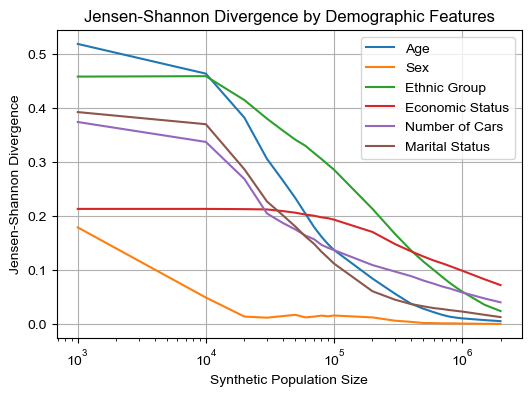

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# set font to Times New Roman
plt.rcParams['font.family'] = 'Arial'   # Times new roman

plt_name_map = {
    'age':'Age', 
    'sex':'Sex', 
    'ethnic_group':'Ethnic Group', 
    'economic_activity':'Economic Status',
    'number_of_cars_and_vans':'Number of Cars', 
    'marital_status':'Marital Status'
}
df = pop_verify_df.copy()
df['pop_size'] = list(map(float, df['pop_size']))

plt.figure(figsize=(6, 4))

for col in check_features:
    plt.plot(df['pop_size'], df[col], label=plt_name_map[col])

plt.xlabel('Synthetic Population Size')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Jensen-Shannon Divergence by Demographic Features')
# plt.xticks(rotation=45)
plt.xscale('log')
plt.legend()
plt.grid(True)
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-pop.png", dpi=600, bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-pop.pdf", bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "poster-jsd-pop.png", dpi=600, bbox_inches='tight') 
plt.show()

### 3.2 Validation of Synthetic Orders

Uni-variate validation.

In [ ]:
check_instances = [
                  '1e0', '2e0', '3e0', '4e0', '5e0', '6e0', '7e0', '8e0', '9e0'
                  '1e1', '2e1', '3e1', '4e1', '5e1', '6e1', '7e1', '8e1', '9e1'
                  '1e2', '2e2', '3e2', '4e2', '5e2', '6e2', '7e2', '8e2', '9e2',
                  '1e3', '2e3', '3e3', '4e3', '5e3', '6e3', '7e3', '8e3', '9e3',
                  '1e4', '2e4', '3e4', '4e4', '5e4', '6e4', '7e4', '8e4', '9e4', 
                  '1e5', '2e5', '3e5', '4e5', '5e5', '6e5', '7e5', '8e5', '9e5',
                  '1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6',
                ] 

random_seeds = [i for i in range(20)] + [42]

### 3.2.1 Order Feature (Category)
Validation Data Source: [Online shopping behavior in the United Kingdom (UK)](https://www.statista.com/study/22395/online-shopping-in-the-united-kingdom-statista-dossier/)

In [ ]:
import statistics as stat
import pandas as pd
from tqdm import tqdm

from src.config import RES_STATIC, RES_SYN_ORD_PATH

REF_cate = pd.read_excel(RES_STATIC/'verify_order_category.xlsx', sheet_name='data')    # 1 - third party source

check_features = ['Order_Category']


In [ ]:
import statistics as stat 
import pandas as pd
from tqdm import tqdm

from src.validation import freq_table, convert_freq_dict_to_vector, get_js_distance

res = []

for seed in tqdm(random_seeds, desc=f'Checking Progress'):
    for instance in check_instances:
        try:
            syn_ord_name = 'synthetic_order_' + instance + f'_{seed}.csv'
            syn_ord_df = pd.read_csv(RES_SYN_ORD_PATH / syn_ord_name)

            check_res = {}
            check_res['pop_size'] = instance
            check_res['seed'] = seed

            for feature in check_features:
            
                samples_X = syn_ord_df[feature]
                
                freq_X = freq_table(samples_X)
                freq_Y = REF_cate['Probability'].to_dict()

                # Build the common support set (union of values)
                support_1d = sorted(set(freq_X) | set(freq_Y))

                # Convert freq dicts to aligned vectors
                p_vec = convert_freq_dict_to_vector(freq_X, support_1d)
                q_vec = convert_freq_dict_to_vector(freq_Y, support_1d)

                # Compute JS distance
                js_dist_1d = get_js_distance(p_vec, q_vec)
                # print(js_dist_1d)

                # js_var =  stat.variance(js_values_per_area)     # variance
                check_res[feature] = js_dist_1d
            
            res.append(check_res)
        except:
            # print(f'No This file: synthetic_order_{instance}_{seed}.csv !')
            continue

order_verify_df = pd.DataFrame(res)
# order_verify_df.to_csv(RES_STATIC/'JSD_syn_ord.csv', index=False)

In [ ]:
order_verify_df.head()

,pop_size,seed,Order_Category
0,2e0,0,0.581293
1,4e0,0,0.581293
2,6e0,0,0.352891
3,8e0,0,0.249177
4,2e1,0,0.150890


In [ ]:
import pandas as pd
from src.config import RES_STATIC, RES_SYN_ORD_PATH

# read data
df_ori = pd.read_csv(RES_STATIC/'JSD_syn_ord.csv')
df = df_ori[df_ori['pop_size'] >= 5]

d:\Software\Anaconda3\envs\msc-dis\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


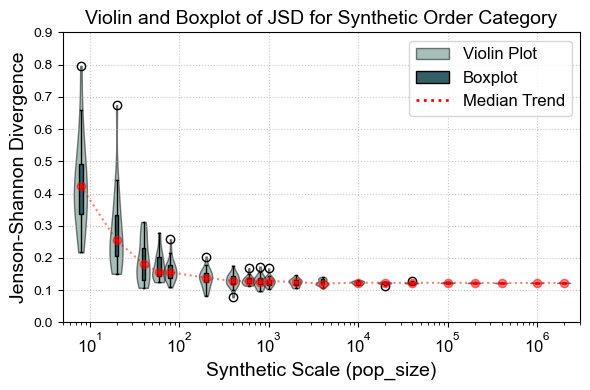

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'Arial'  # Times New Roman
plt.rcParams['xtick.labelsize'] = 12

fig, ax = plt.subplots(figsize=(6,4))

# 1️⃣ category and width
categories = np.sort(df['pop_size'].unique())
positions = categories
widths = categories/3

# prepare data
data = [df.loc[df['pop_size']==cat, "Order_Category"] for cat in categories]

# 2️⃣ Main: violin plot
parts = ax.violinplot(
    dataset=data,
    positions=positions,
    widths=widths,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

for pc in parts['bodies']:
    pc.set_facecolor('#4d8075')     # light green
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

# 3️⃣ Main: boxplot plot
medians = []
for i, cat_data in enumerate(data):
    bp = ax.boxplot(
        cat_data,
        positions=[positions[i]],
        widths=widths[i]*0.3,
        patch_artist=True,
        boxprops=dict(facecolor='#335f69', color='black', linewidth=1),  # dark green
        medianprops=dict(color='red', linewidth=2),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1)
    )
    # get median
    median_val = bp['medians'][0].get_ydata()[0]
    medians.append(median_val)

# 4️⃣ Connect medians with a line
ax.plot(positions, medians, color='red', linestyle=':', marker='o', label='Median Trend', alpha=0.5)

# 5️⃣ set log x axis
ax.set_xscale('log')
ax.set_ylim(0, 0.9)
ax.set_xlim(5, 3e6)

# 6️⃣ labels
ax.set_xlabel("Synthetic Scale (pop_size)", fontsize=14)
ax.set_ylabel("Jenson-Shannon Divergence", fontsize=14)
ax.set_title('Violin and Boxplot of JSD for Synthetic Order Category', fontsize=14)

# 7️⃣ Add grid
ax.grid(which='major', axis='both', linestyle=':', linewidth=0.8, alpha=0.7)

# 8️⃣ Add legend
legend_elements = [
    Patch(facecolor='#4d8075', edgecolor='black', alpha=0.5, label='Violin Plot'),
    Patch(facecolor='#335f69', edgecolor='black', label='Boxplot'),
    Line2D([0], [0], color='red', linestyle=':', lw=2, label='Median Trend')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-ord.png", dpi=600, bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-ord.pdf", bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "poster-jsd-ord.png", dpi=600, bbox_inches='tight') 
plt.show()

### 3.2.2 Customer Feature (Age)
Validation Data Source: [Online shopping behavior in the United Kingdom (UK)](https://www.statista.com/study/22395/online-shopping-in-the-united-kingdom-statista-dossier/)

In [ ]:
import statistics as stat
import pandas as pd
from tqdm import tqdm

from src.config import RES_STATIC, RES_SYN_ORD_PATH, RES_SYN_POP_SAMPLE

REF_age = pd.read_excel(RES_STATIC/'verify_customer_age.xlsx', sheet_name='data')

check_customer = ['age']

In [ ]:
import statistics as stat 
import pandas as pd
from tqdm import tqdm

from src.validation import freq_table, convert_freq_dict_to_vector, get_js_distance

res = []

for seed in tqdm(random_seeds, desc=f"Checking Progress'"):
    # print(seed)
    for instance in check_instances:
        try:
            syn_ord_name = f'synthetic_order_{instance}_{seed}.csv'
            syn_pop_name = f'synthetic_population_{instance}_{seed}.csv'
            # print(syn_ord_name)

            syn_ord_df = pd.read_csv(RES_SYN_ORD_PATH / syn_ord_name)
            syn_pop_df = pd.read_csv(RES_SYN_POP_SAMPLE / syn_pop_name)

            df = syn_ord_df.merge(syn_pop_df, left_on='Customer_ID', right_on='Person_ID').copy()
            # df = syn_ord_df.merge(syn_pop_df, left_on='Customer_ID', right_on='Person_ID')[['Customer_ID', 'age']].drop_duplicates().copy()
            check_res = {}
            check_res['pop_size'] = instance
            check_res['seed'] = seed

            for feature in check_customer:
            
                samples_X = df[feature]
                
                freq_X = freq_table(samples_X)
                freq_Y = REF_age['Probability'].to_dict()
                
                # print(f'{instance}', freq_X)

                # Build the common support set (union of values)
                support_1d = sorted(set(freq_X) | set(freq_Y))

                # Convert freq dicts to aligned vectors
                p_vec = convert_freq_dict_to_vector(freq_X, support_1d)
                q_vec = convert_freq_dict_to_vector(freq_Y, support_1d)

                # Compute JS distance
                js_dist_1d = get_js_distance(p_vec, q_vec)
                # print(js_dist_1d)

                # js_var =  stat.variance(js_values_per_area)     # variance
                check_res[feature] = js_dist_1d
            
            res.append(check_res)
        except:
            # tqdm.write(f'No This file: synthetic_order_{instance}_{seed}.csv !')
        # except Exception as e:
        #     tqdm.write(f'Error for file {syn_ord_name}: {e}')
            continue
     
customer_check_res_df = pd.DataFrame(res)
# customer_check_res_df.to_csv(RES_STATIC/'JSD_syn_customer_age.csv', index=False)

In [ ]:
import pandas as pd
from src.config import RES_STATIC, RES_SYN_ORD_PATH

# read data
df_ori = pd.read_csv(RES_STATIC/'JSD_syn_customer_age.csv')
df = df_ori[df_ori['pop_size'] >= 5]

d:\Software\Anaconda3\envs\msc-dis\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


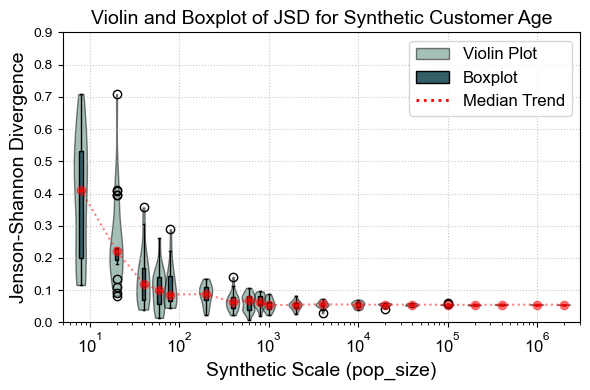

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'Arial'# 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12

fig, ax = plt.subplots(figsize=(6, 4))

# 1️⃣ category and width
categories = np.sort(df['pop_size'].unique())
positions = categories
widths = categories/3

# prepare data
data = [df.loc[df['pop_size']==cat, "age"] for cat in categories]

# 2️⃣ Main: violin plot
parts = ax.violinplot(
    dataset=data,
    positions=positions,
    widths=widths,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

for pc in parts['bodies']:
    pc.set_facecolor('#4d8075')     # light green
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

# 3️⃣ Main: boxplot plot
medians = []
for i, cat_data in enumerate(data):
    bp = ax.boxplot(
        cat_data,
        positions=[positions[i]],
        widths=widths[i]*0.3,
        patch_artist=True,
        boxprops=dict(facecolor='#335f69', color='black', linewidth=1),  # dark green
        medianprops=dict(color='red', linewidth=2),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1)
    )
    # get median
    median_val = bp['medians'][0].get_ydata()[0]
    medians.append(median_val)

# 4️⃣ Connect medians with a line
ax.plot(positions, medians, color='red', linestyle=':', marker='o', label='Median Trend', alpha=0.5)

# 5️⃣ set log x axis
ax.set_xscale('log')
ax.set_ylim(0, 0.9)
ax.set_xlim(5, 3e6)

# 6️⃣ labels
ax.set_xlabel("Synthetic Scale (pop_size)", fontsize=14)
ax.set_ylabel("Jenson-Shannon Divergence", fontsize=14)
ax.set_title('Violin and Boxplot of JSD for Synthetic Customer Age', fontsize=14)

# 7️⃣ Add grid
ax.grid(which='major', axis='both', linestyle=':', linewidth=0.8, alpha=0.7)

# 8️⃣ Add legend
legend_elements = [
    Patch(facecolor='#4d8075', edgecolor='black', alpha=0.5, label='Violin Plot'),
    Patch(facecolor='#335f69', edgecolor='black', label='Boxplot'),
    Line2D([0], [0], color='red', linestyle=':', lw=2, label='Median Trend')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-age.png", dpi=600, bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "jsd-age.pdf", bbox_inches='tight') 
# plt.savefig(RES_STATIC / 'Figures'/ "poster-jsd-age.png", dpi=600, bbox_inches='tight') 
plt.show()
